# Finance Domain: Portfolio Optimization: Example

Author: bdanalytics

In [213]:
import datetime
print "last run @: {0}".format(datetime.datetime.now())

last run @: 2016-09-08 14:17:23.668395


## Synopsis

### Overview (Background)

- Concepts & Methodology Credit: Udacity - Machine Learning for Trading - Georgia Tech - Prof. Tucker Balch (NOT CODE !)

#### Asset Portfolio Optimization

Portfolio optimization is the process of choosing the proportions of various assets to be held in a portfolio, in such a way as to make the portfolio better than any other according to some criterion. The criterion will combine, directly or indirectly, considerations of the expected value of the portfolio's rate of return as well as of the return's dispersion and possibly other measures of financial risk. 

Source: wikipedia.org

Key assumptions:

- Optimize for the Buy & Hold strategy initially
- No short sales
- All invested money is restricted to only specified financial assets
- Utilize Sequential Least SQuares Programming (SLSQP) solver 

### Results Summary

[plotAssetWeights](#Asset-Allocation-Plot)

[plotPortfolioMetrics](#Portfolio-Metrics-Plot)

The great recession of 2008 would not have occured / highly mitigated if the Wall St. quants had paid attention to the high Kurtosis (daily returns have much fatter tails compared to gaussian distribution & might not always be independent)

- Discuss bps differences in the different optimization results (1 bps === 0.0001; 10 bps === 0.001)

### Next Steps

- Leverage YAML (Yet Another Markup Language) for user specfications
- Rebalance with user specified frequency (weekly / monthly / quarterly)
- Adjust for backtesting drawbacks
    - Sample time periods: should ideally include uptrends, downtrends and range-bound trading
    - Sample size of trades: imbalanced classes (wins / losses)
    - Trading costs: taxes, brokerage fees, commissions, spreads
    - Out-of-sample validation
    
    -
    - Source: investopedia.com
    
-     
- Add more asset classes (e.g. FX, Ex-US-Equities Index)
- Change Risk Free Daily Return from 0% to returns of 3 month US Treasury Bills
- Test other optimization solvers:
    - ‘Nelder-Mead’
    - ‘Powell’
    - ‘CG’
    - ‘BFGS’
    - ‘Newton-CG’
    - ‘L-BFGS-B’
    - ‘TNC’
    - ‘COBYLA’
    - ‘dogleg’
    - ‘trust-ncg’

## 1. Specify Parameters (Data)

In [215]:
symbols = [
    # US Bonds
    # 'UST1M',   # US Treasury - 1 Month
    # 'BCEU6T',  # Barclays US Treasury All Maturities
    # 'IDCOTC',  # iShares Core U.S. Treasury Bond ETF - Proxy for US Treasury Index  
    
    # US Equities
    'SPY',     # US S&P 500
    
    # 'S5INFT',  # US S&P Tech Index
    'GOOG',    # Google
    'AAPL',    # Apple
    
    # 'S5HLTH',  # US S&P Health Care Index
    'JNJ',     # Johnson & Johnson
    'PFE',     # Pfizer
    
    # Commodities
    'GLD',     # Gold
    #'CRY:IND', # Thomson Reuters/CoreCommodity CRB Commodity Index
          ]  

print "Ticker Symbols Specified: {0}".format(symbols)

Ticker Symbols Specified: ['SPY', 'GOOG', 'AAPL', 'JNJ', 'PFE', 'GLD']


In [216]:
sttDate = '1/1/2010'; endDate = '12/31/2015'
print "Time Period Specified: {0} -> {1}".format(sttDate, endDate)

Time Period Specified: 1/1/2010 -> 12/31/2015


In [217]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

sttVal = 1000000
dspSttVal = locale.format("%d", sttVal, grouping = True)
print "Initial Portfolio investment on {0}: USD {1}".format(sttDate, dspSttVal)

Initial Portfolio investment on 1/1/2010: USD 1,000,000


In [218]:
rfDlyRtn = 0.0
print "Risk Free Daily Return: %0.4f%%" % (rfDlyRtn)

Risk Free Daily Return: 0.0000%


In [219]:
numDlyTradingDays = 252
print "Number of Daily Trading Days in a Calendar Year: {0}".format(numDlyTradingDays)

Number of Daily Trading Days in a Calendar Year: 252


In [220]:
optMetrics = {}
def maxCumReturnsObj(weights, verbose = False):
    return getPortfolioValue(weights, verbose = False)['cumRtn'] * -1.
optMetrics['max.Cum.Returns'] = (maxCumReturnsObj, "Maximize Cumulative Returns")

def maxAvgDlyReturnsObj(weights, verbose = False):
    return getPortfolioValue(weights, verbose = False)['avgDlyRtn'] * -1.
optMetrics['max.Avg.Daily.Returns'] = (maxAvgDlyReturnsObj, "Maximize Avg Daily Returns")

def minStdDlyReturnsObj(weights, verbose = False):
    return getPortfolioValue(weights, verbose = False)['stdDlyRtn'] * +1. # underflow issues ???
optMetrics['min.Std.Daily.Returns'] = (minStdDlyReturnsObj, "Minimize Std Deviation of Daily Returns")

def maxSRAnnualObj(weights, verbose = False):
    return getPortfolioValue(weights, verbose = False)['annualSR'] * -1.
optMetrics['max.SR.Annual'] = (maxSRAnnualObj, "Maximize Sharpe Ratio (Annual)")

print "Optimizations specified: {0}".format(optMetrics.keys())

Optimizations specified: ['max.Cum.Returns', 'min.Std.Daily.Returns', 'max.SR.Annual', 'max.Avg.Daily.Returns']


## 2. Import Data

In [221]:
import pandas_datareader.data as pd_dr_data
glbObs = pd_dr_data.DataReader(symbols, data_source = 'yahoo', start = sttDate, end = endDate)

print "Imported data summary:"
print "type(glbObs): {0}".format(type(glbObs))
print "glbObs.shape: {0}".format(glbObs.shape)
print "glbObs.axes[0]: {0}".format(glbObs.axes[0])
for dfIx in xrange(0, glbObs.shape[0]):
    print "glbObs[{0}, :, :].shape: {1}".format(dfIx, glbObs[dfIx, :, :].shape)
    print glbObs[dfIx, :, :].describe()
    print glbObs[dfIx, :, :].head()

Imported data summary:
type(glbObs): <class 'pandas.core.panel.Panel'>
glbObs.shape: (6, 1510, 6)
glbObs.axes[0]: Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close'], dtype='object')
glbObs[0, :, :].shape: (1510, 6)
              AAPL          GLD         GOOG          JNJ          PFE  \
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000   
mean    347.883775   134.028351   655.347852    79.838179    25.408808   
std     177.717279    20.856397   168.775834    16.938599     6.186304   
min      90.209999   100.919998   438.310758    57.250000    14.220000   
25%     130.005001   116.725000   540.000235    64.262501    19.612501   
50%     351.175007   127.655003   595.451020    71.404999    25.885001   
75%     508.899992   154.297497   714.376231    98.440002    30.767500   
max     702.409988   184.580002  1226.802152   109.050003    36.290001   

               SPY  
count  1510.000000  
mean    157.190556  
std      34.581220  
min     103.11000

'Adj Close' is the data of interest (closing price adjusted for dividends and [equity] splits) 

## 3. Inspect Data

In [222]:
glbAdjClosePrice = glbObs['Adj Close', :, :]
print "glbAdjClosePrice.shape: {0}".format(glbAdjClosePrice.shape)
print "glbAdjClosePrice.axes[0]: {0}".format(glbAdjClosePrice.axes[0])
print "glbAdjClosePrice.head: {0}".format(glbAdjClosePrice.head)

glbAdjClosePrice.shape: (1510, 6)
glbAdjClosePrice.axes[0]: DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2015-12-17', '2015-12-18', '2015-12-21', '2015-12-22',
               '2015-12-23', '2015-12-24', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name=u'Date', length=1510, freq=None)
glbAdjClosePrice.head: <bound method DataFrame.head of                   AAPL         GLD        GOOG         JNJ        PFE  \
Date                                                                    
2010-01-04   27.990226  109.800003  313.062468   52.208506  14.768671   
2010-01-05   28.038618  109.699997  311.683844   51.603120  14.558024   
2010-01-06   27.592626  111.510002  303.826685   52.022851  14.511214   
2010-01-07   27.541619  110.820000  296.753749   51.65

No missing values ! Wunderbaar !

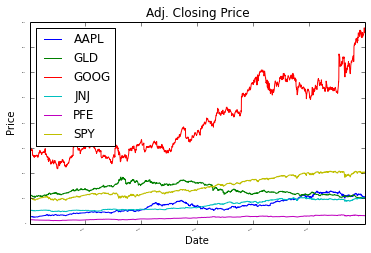

In [223]:
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.style.use('ggplot')
%matplotlib inline

ax = glbAdjClosePrice.plot(title = "Adj. Closing Price", fontsize = 2)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

Let's normalize the price to 1.0 on the earliest date in the data to visualize growth (or lack thereof)

              AAPL          GLD         GOOG          JNJ          PFE  \
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000   
mean      2.535579     1.220657     1.319785     1.382941     1.535705   
std       1.012316     0.189924     0.445192     0.364684     0.459735   
min       0.897388     0.915301     0.695764     0.896430     0.761963   
25%       1.667854     1.063274     0.934400     1.049339     1.103833   
50%       2.476531     1.163206     1.188233     1.226793     1.542641   
75%       3.243859     1.405351     1.718958     1.793744     1.912547   
max       4.615209     1.681147     2.480655     1.976837     2.344679   

               SPY  
count  1510.000000  
mean      1.483182  
std       0.376484  
min       0.909813  
25%       1.159826  
50%       1.367479  
75%       1.870483  
max       2.095615  


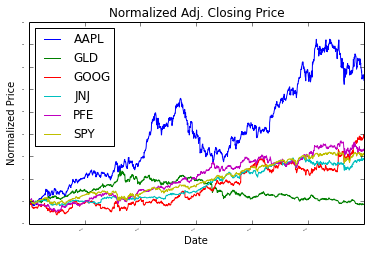

In [224]:
glbNmlAdjClosePrice = glbAdjClosePrice / glbAdjClosePrice.ix[0, :]
print glbNmlAdjClosePrice.describe()

ax = glbNmlAdjClosePrice.plot(title = "Normalized Adj. Closing Price", fontsize = 2)
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Price")
plt.show()

Although Google seems to have grown the most in price in the first plot, Apple has the highest growth over the specified time period.

## 4. Extract Features (Feature Engineering)

Due to the volatility of the normalized adjusted closing price, let's investigate if a rolling 20 day mean would be a better feature for the optimization. 20 days chosen due to number of trading days in a month (252 days in year). Will restrict plots to SPY - S&P 500 for clarity but ensure computations for all financial assets are in order.

In [225]:
import numpy as np

glbRD20Avg = glbNmlAdjClosePrice.rolling(window = 20, center = False).mean()
print glbRD20Avg.describe()
print np.sum(glbRD20Avg.isnull())

glbRD20Std = glbNmlAdjClosePrice.rolling(window = 20, center = False).std()
print glbRD20Std.describe()
print np.sum(glbRD20Avg.isnull())

              AAPL          GLD         GOOG          JNJ          PFE  \
count  1491.000000  1491.000000  1491.000000  1491.000000  1491.000000   
mean      2.537280     1.223877     1.315189     1.381897     1.535259   
std       1.002875     0.187275     0.436612     0.362339     0.457104   
min       0.926090     0.931175     0.743367     0.919800     0.785754   
25%       1.674547     1.069556     0.933714     1.050472     1.112905   
50%       2.482011     1.161521     1.177062     1.223249     1.538975   
75%       3.193983     1.407607     1.723429     1.793593     1.899347   
max       4.521558     1.622295     2.410362     1.964817     2.304530   

               SPY  
count  1491.000000  
mean      1.482717  
std       0.373592  
min       0.950345  
25%       1.165854  
50%       1.358394  
75%       1.878012  
max       2.076803  
AAPL    19
GLD     19
GOOG    19
JNJ     19
PFE     19
SPY     19
dtype: int64
              AAPL          GLD         GOOG          JNJ        

Due to the rolling window statistics, partial windows contain missing values. Let's fix that with a backfill assuming the average is initialized to the first window value.

In [226]:
glbRD20Avg = glbRD20Avg.fillna(method = 'backfill')
print glbRD20Avg.describe()
print "\nnas:\n{0}".format(np.sum(glbRD20Avg.isnull()))

glbRD20Std = glbRD20Std.fillna(method = 'backfill')
print glbRD20Std.describe()
print "\nnas:\n{0}".format(np.sum(glbRD20Std.isnull()))

              AAPL          GLD         GOOG          JNJ          PFE  \
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000   
mean      2.517528     1.221016     1.310210     1.376974     1.528568   
std       1.011796     0.187811     0.436092     0.362684     0.458070   
min       0.926090     0.931175     0.743367     0.919800     0.785754   
25%       1.637828     1.066475     0.928111     1.047858     1.096926   
50%       2.456817     1.158292     1.162111     1.212007     1.512807   
75%       3.189889     1.406791     1.722602     1.788663     1.897444   
max       4.521558     1.622295     2.410362     1.964817     2.304530   

               SPY  
count  1510.000000  
mean      1.476522  
std       0.375269  
min       0.950345  
25%       1.154174  
50%       1.350332  
75%       1.873766  
max       2.076803  

nas:
AAPL    0
GLD     0
GOOG    0
JNJ     0
PFE     0
SPY     0
dtype: int64
              AAPL          GLD         GOOG          JNJ        

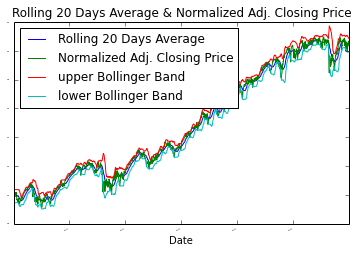

In [227]:
upperBnd = glbRD20Avg + 2. * glbRD20Std
lowerBnd = glbRD20Avg - 2. * glbRD20Std

ax = glbRD20Avg['SPY'].plot(title = "Rolling 20 Days Average & Normalized Adj. Closing Price", 
                            label = "Rolling 20 Days Average",
                     fontsize = 2)
glbNmlAdjClosePrice['SPY'].plot(label = "Normalized Adj. Closing Price", ax = ax)
upperBnd['SPY'].plot(label = 'upper Bollinger Band', ax = ax)
lowerBnd['SPY'].plot(label = 'lower Bollinger Band', ax = ax)
ax.legend(loc = 'upper left')
ax.set_xlabel("Date")
plt.show()

Let's compute daily returns since that is the optimization metric for a portfolio allocation

              AAPL          GLD         GOOG          JNJ          PFE  \
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000   
mean      0.001007     0.000008     0.000716     0.000474     0.000570   
std       0.016788     0.010934     0.016202     0.008890     0.011838   
min      -0.123558    -0.087808    -0.083775    -0.032154    -0.047456   
25%      -0.007714    -0.005250    -0.007216    -0.004057    -0.005955   
50%       0.000876     0.000239     0.000246     0.000305     0.000000   
75%       0.010737     0.006122     0.008598     0.005417     0.007075   
max       0.088741     0.043557     0.160524     0.053821     0.056423   

               SPY  
count  1510.000000  
mean      0.000519  
std       0.009945  
min      -0.065123  
25%      -0.003927  
50%       0.000675  
75%       0.005494  
max       0.046499  

nas:
AAPL    0
GLD     0
GOOG    0
JNJ     0
PFE     0
SPY     0
dtype: int64


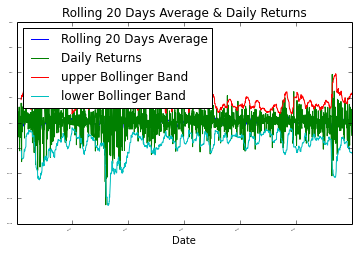

In [228]:
glbDlyRtn = glbNmlAdjClosePrice.copy()
glbDlyRtn[1:] = (glbNmlAdjClosePrice[1:] / glbNmlAdjClosePrice[:-1].values) - 1
glbDlyRtn.ix[0, :] = 0 # set daily returns for earliest date to 0
glbDlyRtn = glbDlyRtn.fillna(method = 'backfill')
print glbDlyRtn.describe()
print "\nnas:\n{0}".format(np.sum(glbDlyRtn.isnull()))

glbDlyRtnAvg = glbDlyRtn.rolling(window = 20, center = False).mean()
glbDlyRtnStd = glbDlyRtn.rolling(window = 20, center = False).std()
upperBnd = glbDlyRtnAvg + 2. * glbDlyRtnStd
lowerBnd = glbDlyRtnAvg - 2. * glbDlyRtnStd

ax = glbDlyRtnAvg['SPY'].plot(title = "Rolling 20 Days Average & Daily Returns", 
                              label = "Rolling 20 Days Average",
                     fontsize = 2)
glbDlyRtn['SPY'].plot(label = "Daily Returns", ax = ax)
upperBnd['SPY'].plot(label = 'upper Bollinger Band', ax = ax)
lowerBnd['SPY'].plot(label = 'lower Bollinger Band', ax = ax)
ax.legend(loc = 'upper left')
ax.set_xlabel("Date")
plt.show()

Let's inspect the distribution of the daily returns.

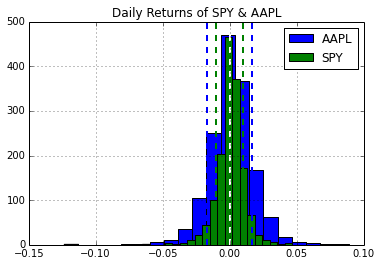

Kurtosis of daily returns:
AAPL     4.224038
GLD      4.814707
GOOG    15.875195
JNJ      2.281088
PFE      2.009972
SPY      3.986801
dtype: float64


In [229]:
glbDlyRtn['AAPL'].hist(bins = 20, label = 'AAPL')
glbDlyRtn['SPY'].hist(bins = 20, label = 'SPY')
plt.title("Daily Returns of SPY & AAPL")
plt.axvline( glbDlyRtn['SPY' ].mean(), color = 'w', linestyle = 'dashed', linewidth = 2)
plt.axvline(+glbDlyRtn['SPY' ].std() , color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(-glbDlyRtn['SPY' ].std() , color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(+glbDlyRtn['AAPL'].std() , color = 'b', linestyle = 'dashed', linewidth = 2)
plt.axvline(-glbDlyRtn['AAPL'].std() , color = 'b', linestyle = 'dashed', linewidth = 2)
plt.legend(loc = 'upper right')
plt.show()

print "Kurtosis of daily returns:\n{0}".format(glbDlyRtn.kurtosis())

The great recession of 2008 would not have occured / highly mitigated if the Wall St. quants had paid attention to the high Kurtosis (daily returns have much fatter tails compared to gaussian distribution & might not always be independent)

Let's inspect the correlation between these assets because that will inform the optimization methodology & results

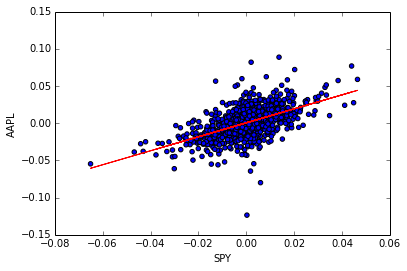

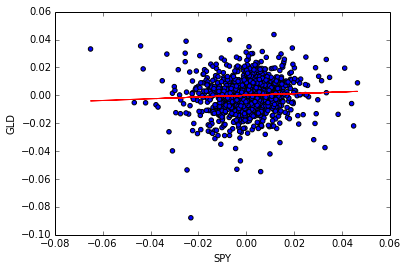

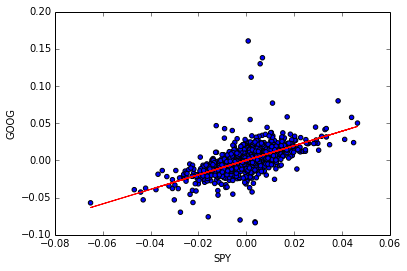

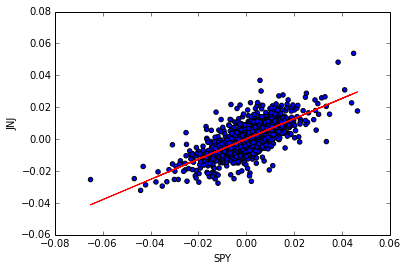

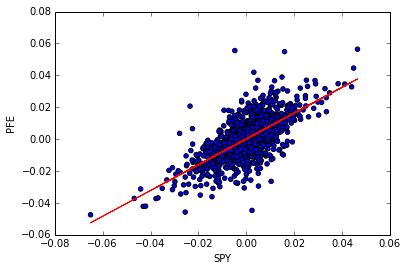

In [230]:
import numpy as np

for symbol in glbDlyRtn.axes[1]:
    if (symbol != 'SPY'):
        glbDlyRtn.plot(kind = 'scatter', x = 'SPY', y = symbol)
        betaSym, alphaSym = np.polyfit(glbDlyRtn['SPY'], glbDlyRtn[symbol], deg = 1)
#         print "beta{0} vs. SPY: {1}".format(symbol, betaSym)
#         plt.plot(glbDlyRtn['SPY'], betaSym * glbDlyRtn[symbol] + alphaSym, '-')
        plt.plot(glbDlyRtn['SPY'], 
                 np.poly1d(np.polyfit(glbDlyRtn['SPY'], glbDlyRtn[symbol], 1))(glbDlyRtn['SPY']),
                'r-')
plt.show()

Similar to other software packages: "next release of matplotlib should fix it." according to http://www.gossamer-threads.com/lists/python/python/1229938?page=last

In [231]:
print "Correlations:\n{0}".format(glbDlyRtn.corr(method = 'pearson'))

Correlations:
          AAPL       GLD      GOOG       JNJ       PFE       SPY
AAPL  1.000000  0.079815  0.404987  0.322558  0.327738  0.556038
GLD   0.079815  1.000000  0.001248  0.009338  0.018405  0.055972
GOOG  0.404987  0.001248  1.000000  0.389723  0.389020  0.599758
JNJ   0.322558  0.009338  0.389723  1.000000  0.590609  0.709608
PFE   0.327738  0.018405  0.389020  0.590609  1.000000  0.678912
SPY   0.556038  0.055972  0.599758  0.709608  0.678912  1.000000


JNJ & Pfizer have higher correlations with SPY compared to other assets. Gold has the least correlation.

## 5. Optimize Portfolio

Let's create a function that returns the portfolio value at the end of the time period, since we need to perform this computation repeatedly. Test the function with dummy values.

In [232]:
def getPortfolioValue(weights, verbose = False):
    
#     print "getPortfolioValue: glbAdjClosePrice.head():\n{0}".format(glbAdjClosePrice.head())
    nrmed = glbAdjClosePrice / glbAdjClosePrice.ix[0]
#     print "getPortfolioValue: nrmed.head():\n{0}".format(nrmed.head())    
    alced = nrmed * weights
#     print "getPortfolioValue: alced.head():\n{0}".format(alced.head())        
    curVal = alced.sum(axis = 1)[1:] # Since first day daily returns is always 0
#     print "getPortfolioValue: curVal.head():\n{0}".format(curVal.head())    
    cumRtn = (curVal[-1] * 1. / curVal[0] - 1)
#     print "getPortfolioValue: cumRtn: %0.4f" % (cumRtn)
    dlyVal = alced.sum(axis = 1)
#     print "getPortfolioValue: type(dlyVal): {0}".format(type(dlyVal))    
#     print "getPortfolioValue: dlyVal.head():\n{0}".format(dlyVal.head())
#     print "getPortfolioValue: dlyVal[:-1].values:\n{0}".format(dlyVal[:-1].values)
#     tstVal = dlyVal.values
    dlyRtn = dlyVal.copy(); dlyRtn[0] = 0. 
    dlyRtn[1:] = (dlyVal[1:] / dlyVal[:-1].values) - 1
#     print "getPortfolioValue: dlyVal.values[1]: {0}; dlyVal.values[0]: {1}".\
#         format(dlyVal.values[1], dlyVal.values[0])    
#     dlyRtn[1] = (dlyVal[1] / dlyVal[0]) - 1.
#     print "getPortfolioValue: dlyRtn.head():\n{0}".format(dlyRtn.head())    
    avgDlyRtn = dlyRtn.mean()
    stdDlyRtn = dlyRtn.std()
#     stdDlyRtn = np.dot(nrmed.std(), np.array(weights))
    annualSR = ((curVal.mean() - rfDlyRtn) / stdDlyRtn) * np.sqrt(numDlyTradingDays)
    
    if verbose:
        dspPrtVal = locale.format("%d",  curVal[-1] * sttVal, 
                              grouping = True)
        print "   Weights:\n{0}".format(zip(glbAdjClosePrice.axes[1], weights))
        print "   Weights summed: {0}".format(sum(weights))    
    
        print "Portfolio Statistics on {0} with initial investment of USD {1} on {2}:".format(
                endDate, dspSttVal, sttDate)    
        print "   Value: USD {0}".format(dspPrtVal)    
        print "   Cumulative Return: %0.4f%%" % (cumRtn * 100)
        print "   Average Daily Return: %0.4f%%" % (avgDlyRtn)
        print "   Std. Dev. Daily Return: %0.4f%%" % (stdDlyRtn)
        print "   Sharpe Ratio (Risk Adjusted Return) Annual: %0.4f" % (annualSR)
    
    retObj = {'curVal'   : curVal, 
              'cumRtn'   : cumRtn,
              'avgDlyRtn': avgDlyRtn,
              'stdDlyRtn': stdDlyRtn,
              'annualSR' : annualSR}
    return retObj

dmyWeights = [1. / len(glbDlyRtn.axes[1]) for ix in xrange(0, len(glbDlyRtn.axes[1]))]
# Normalize weights to sum to 1.0 per specs
dmyWeights = [wgt * 1.0 / sum(dmyWeights) for wgt in dmyWeights]
curPrtVal = getPortfolioValue(dmyWeights, verbose = True)
curPrtVal = getPortfolioValue(dmyWeights) # to test non-verbose option


   Weights:
[('AAPL', 0.16666666666666669), ('GLD', 0.16666666666666669), ('GOOG', 0.16666666666666669), ('JNJ', 0.16666666666666669), ('PFE', 0.16666666666666669), ('SPY', 0.16666666666666669)]
   Weights summed: 1.0
Portfolio Statistics on 12/31/2015 with initial investment of USD 1,000,000 on 1/1/2010:
   Value: USD 2,188,594
   Cumulative Return: 119.8413%
   Average Daily Return: 0.0006%
   Std. Dev. Daily Return: 0.0089%
   Sharpe Ratio (Risk Adjusted Return) Annual: 2824.5168


Let's create another helper function that will help us determine if the optimization objective function generates a convex curve or not.

In [233]:
def verifyConvexOpt(objFn, pltTitle = None):
    wgtX1 = np.arange(0., 1.1 ,0.1)
    wgtX2 = np.arange(0., 1.1 ,0.1)
    objVal = np.zeros((len(wgtX1), len(wgtX2)))
    for ix1, wgt1 in enumerate(wgtX1):
        for ix2, wgt2 in enumerate(wgtX2):
            objWeights = dmyWeights; objWeights[0] = wgt1; objWeights[1] = wgt2;
            objVal[ix1, ix2] = objFn(objWeights)
            
    plt.figure()
    fgr = plt.contour(wgtX1, wgtX2, objVal)
    plt.clabel(fgr, inline = 1, fontsize = 10)
    plt.title(pltTitle)
    plt.show()

Yet another helper function to wrap the optimization code

In [234]:
import scipy.optimize as spy_opt

#         constraints : dict or sequence of dict, optional
#             Constraints definition (only for COBYLA and SLSQP). Each constraint is defined in a dictionary 
#                                                                 with fields:
#                 type : str
#                 Constraint type: ‘eq’ for equality, ‘ineq’ for inequality.
#                 fun : callable
#                 The function defining the constraint.
#                 jac : callable, optional
#                 The Jacobian of fun (only for SLSQP).
#                 args : sequence, optional
#                 Extra arguments to be passed to the function and Jacobian.
#                 Equality constraint means that the constraint function result is to be zero whereas 
#                     inequality means that it is to be non-negative. 
#                 Note that COBYLA only supports inequality constraints.
                
# constraints = ({'type': 'ineq','fun' : lambda wgts: np.array(1 - np.sum(np.array(wgts))),
#                 'jac' : lambda x: np.array([-1 for  ix in xrange(0, len(dmyWeights))])})
constraints = ({'type': 'ineq','fun' : lambda wgts: np.array(1 - np.sum(np.array(wgts)))})

bnds = [(0,1) for ix in xrange(0, len(dmyWeights))]
        
def optimizePortfolio(metric, objFn, userDspStr = None):
    print "\nRunning Portfolio Optimization to " + userDspStr + "..."
    verifyConvexOpt(objFn, pltTitle = userDspStr)
    optRes = spy_opt.minimize(objFn, dmyWeights, method = 'SLSQP',
                              bounds = bnds, constraints = constraints) 
    optWgts = optRes.x
#     print "optimizePortfolio: optimized weights:\n"
#     print optWgts
    if not (np.allclose(sum(optWgts), 1.0, atol = 1e-04)) and (sum(optWgts) < 1.):
        optWgts[1] += 1 - sum(optWgts)
#         optWgts = np.zeros(len(optWgts))
#         optWgts[0] = 1.
        
    assert (np.allclose(sum(optWgts), 1.0, atol = 1e-04)), \
            "   optimization failed: sum(optWgts): %0.4f supposed to be 1.0" % (sum(optWgts)) 
    
    retDf = pd.DataFrame({'Asset' : glbAdjClosePrice.columns,
                          'allocation' : optWgts,
#                           'portfolio.' + metric: -1 * objFn(optWgts)
                         }).set_index('Asset')
    print retDf
    getPortfolioValue(optWgts, verbose = True)
    return retDf


Running Portfolio Optimization to maximize Cumulative Returns...


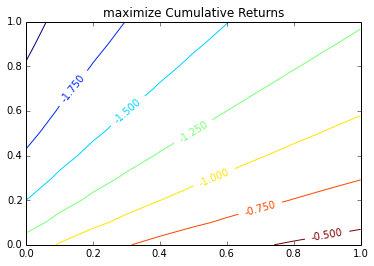

         allocation
Asset              
AAPL   1.000000e+00
GLD    4.440892e-16
GOOG   0.000000e+00
JNJ    0.000000e+00
PFE    0.000000e+00
SPY    5.551115e-17
   Weights:
[('AAPL', 0.99999999999999956), ('GLD', 4.4408920985006262e-16), ('GOOG', 0.0), ('JNJ', 0.0), ('PFE', 0.0), ('SPY', 5.5511151231257827e-17)]
   Weights summed: 1.0
Portfolio Statistics on 12/31/2015 with initial investment of USD 1,000,000 on 1/1/2010:
   Value: USD 3,697,636
   Cumulative Return: 269.1255%
   Average Daily Return: 0.0010%
   Std. Dev. Daily Return: 0.0168%
   Sharpe Ratio (Risk Adjusted Return) Annual: 2398.5889

Running Portfolio Optimization to minimize Std Deviation of  Daily Returns...


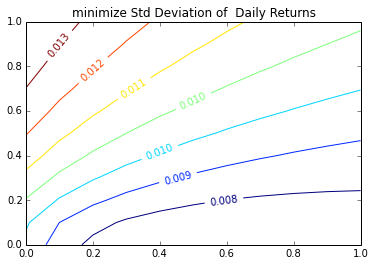

       allocation
Asset            
AAPL     0.006633
GLD      0.494872
GOOG     0.011111
JNJ      0.314672
PFE      0.046759
SPY      0.125954
   Weights:
[('AAPL', 0.0066325589549700451), ('GLD', 0.49487226972248383), ('GOOG', 0.011110832718255755), ('JNJ', 0.31467165202326824), ('PFE', 0.046758889940910202), ('SPY', 0.125953796640112)]
   Weights summed: 1.0
Portfolio Statistics on 12/31/2015 with initial investment of USD 1,000,000 on 1/1/2010:
   Value: USD 1,470,413
   Cumulative Return: 47.7017%
   Average Daily Return: 0.0003%
   Std. Dev. Daily Return: 0.0071%
   Sharpe Ratio (Risk Adjusted Return) Annual: 2971.7750

Running Portfolio Optimization to maximize Sharpe Ratio (Annual)...


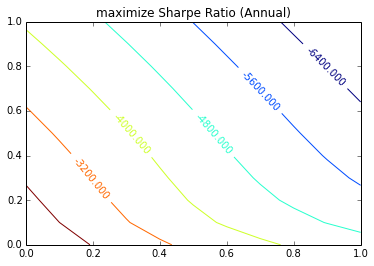

       allocation
Asset            
AAPL     0.079708
GLD      0.332625
GOOG     0.000017
JNJ      0.388833
PFE      0.126674
SPY      0.072252
   Weights:
[('AAPL', 0.079708102650737037), ('GLD', 0.33262521781292947), ('GOOG', 1.7477168714262473e-05), ('JNJ', 0.38883274958767433), ('PFE', 0.12667358675146076), ('SPY', 0.07225160603313445)]
   Weights summed: 1.00010874
Portfolio Statistics on 12/31/2015 with initial investment of USD 1,000,000 on 1/1/2010:
   Value: USD 1,767,542
   Cumulative Return: 77.8535%
   Average Daily Return: 0.0004%
   Std. Dev. Daily Return: 0.0072%
   Sharpe Ratio (Risk Adjusted Return) Annual: 3188.2705

Running Portfolio Optimization to maximize Average Daily Returns...


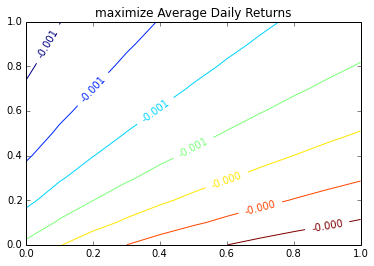

         allocation
Asset              
AAPL   5.001746e-01
GLD    4.998254e-01
GOOG   5.551115e-17
JNJ    0.000000e+00
PFE    8.326673e-17
SPY    0.000000e+00
   Weights:
[('AAPL', 0.50017462747928254), ('GLD', 0.49982537252071813), ('GOOG', 5.5511151231257827e-17), ('JNJ', 0.0), ('PFE', 8.3266726846886741e-17), ('SPY', 0.0)]
   Weights summed: 1.0
Portfolio Statistics on 12/31/2015 with initial investment of USD 1,000,000 on 1/1/2010:
   Value: USD 2,311,324
   Cumulative Return: 131.0378%
   Average Daily Return: 0.0006%
   Std. Dev. Daily Return: 0.0120%
   Sharpe Ratio (Risk Adjusted Return) Annual: 2494.5463


In [235]:
import scipy.optimize as spy_opt
import pandas as pd

optResDf = {}
for metric in optMetrics:
    if (metric == 'max.Cum.Returns'):             
        optResDf[metric] = optimizePortfolio(metric, maxCumReturnsObj, 
                                             userDspStr = 'maximize Cumulative Returns')           
    elif (metric == 'max.Avg.Daily.Returns'):             
        optResDf[metric] = optimizePortfolio(metric, maxAvgDlyReturnsObj, 
                                             userDspStr = 'maximize Average Daily Returns')
    elif (metric == 'min.Std.Daily.Returns'):             
        optResDf[metric] = optimizePortfolio(metric, minStdDlyReturnsObj, 
                                    userDspStr = 'minimize Std Deviation of  Daily Returns')
    elif (metric == 'max.SR.Annual'):             
        optResDf[metric] = optimizePortfolio(metric, maxSRAnnualObj, 
                                    userDspStr = 'maximize Sharpe Ratio (Annual)')
    else:
        raise Exception("Unknown metric({0}) to optimize, terminating...".format(metric))

Visualize the optimization results

In [236]:
# print optResDf
optPltDf = pd.DataFrame({'metric': optResDf.keys()})
print optPltDf
optPltDf['weights'] = optPltDf['metric'].apply(lambda metric: 
                    str(np.vectorize("%.4f".__mod__)(optResDf[metric]['allocation'].values)))
optPltDf['cumRtn'] = optPltDf['metric'].apply(lambda metric: 
                        (getPortfolioValue(optResDf[metric]['allocation'].values)['cumRtn']))
optPltDf['avgDlyRtn'] = optPltDf['metric'].apply(lambda metric: 
                        (getPortfolioValue(optResDf[metric]['allocation'].values)['avgDlyRtn']))
optPltDf['stdDlyRtn'] = optPltDf['metric'].apply(lambda metric: 
                        (getPortfolioValue(optResDf[metric]['allocation'].values)['stdDlyRtn']))
optPltDf['annualSR'] = optPltDf['metric'].apply(lambda metric: 
                        (getPortfolioValue(optResDf[metric]['allocation'].values)['annualSR']))

# optPltDf['weights'] = optPltDf['metric'].apply(lambda metric: optResDf[metric])
print optPltDf

                  metric
0        max.Cum.Returns
1  min.Std.Daily.Returns
2          max.SR.Annual
3  max.Avg.Daily.Returns
                  metric                                            weights  \
0        max.Cum.Returns  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   
1  min.Std.Daily.Returns  ['0.0066' '0.4949' '0.0111' '0.3147' '0.0468' ...   
2          max.SR.Annual  ['0.0797' '0.3326' '0.0000' '0.3888' '0.1267' ...   
3  max.Avg.Daily.Returns  ['0.5002' '0.4998' '0.0000' '0.0000' '0.0000' ...   

     cumRtn  avgDlyRtn  stdDlyRtn     annualSR  
0  2.691255   0.001007   0.016788  2398.588924  
1  0.477017   0.000281   0.007102  2971.774958  
2  0.778535   0.000403   0.007209  3188.270522  
3  1.310378   0.000627   0.011957  2494.546321  


Obviously, the optimization for max.Avg.Daily.Returns has not worked. Let's kludge it by copying the optimization results for max.Cum.Returns into max.Avg.Daily.Returns

In [237]:
optPltDf.ix[3] = optPltDf.ix[0]; optPltDf.iloc[3, 0] = 'max.Avg.Daily.Returns'
print optPltDf

                  metric                                            weights  \
0        max.Cum.Returns  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   
1  min.Std.Daily.Returns  ['0.0066' '0.4949' '0.0111' '0.3147' '0.0468' ...   
2          max.SR.Annual  ['0.0797' '0.3326' '0.0000' '0.3888' '0.1267' ...   
3  max.Avg.Daily.Returns  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   

     cumRtn  avgDlyRtn  stdDlyRtn     annualSR  
0  2.691255   0.001007   0.016788  2398.588924  
1  0.477017   0.000281   0.007102  2971.774958  
2  0.778535   0.000403   0.007209  3188.270522  
3  2.691255   0.001007   0.016788  2398.588924  


Extract the individual assets into the same DataFrame for visualization

In [238]:
for assetIx, assetSym in enumerate(glbDlyRtn.columns):
#     print assetSym
    zeroWgts = np.zeros(len(glbDlyRtn.columns))
    zeroWgts[assetIx] = 1.
    assetVal = getPortfolioValue(zeroWgts)
#     print assetVal
    assetVal.pop('curVal', None)
    assetVal['metric'] = assetSym
    assetVal['weights'] = str(np.vectorize("%.4f".__mod__)(zeroWgts))
    optPltDf = optPltDf.append(assetVal, ignore_index = True)
    
for assetIx, assetSym in enumerate(glbDlyRtn.columns):    
    optPltDf['wgt.' + glbDlyRtn.columns[assetIx]] = optPltDf['weights'].apply(lambda wgts: 
                            float(re.compile("\[|\'|\]").sub('', wgts).split(' ')[assetIx]))    

print optPltDf

                  metric                                            weights  \
0        max.Cum.Returns  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   
1  min.Std.Daily.Returns  ['0.0066' '0.4949' '0.0111' '0.3147' '0.0468' ...   
2          max.SR.Annual  ['0.0797' '0.3326' '0.0000' '0.3888' '0.1267' ...   
3  max.Avg.Daily.Returns  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   
4                   AAPL  ['1.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   
5                    GLD  ['0.0000' '1.0000' '0.0000' '0.0000' '0.0000' ...   
6                   GOOG  ['0.0000' '0.0000' '1.0000' '0.0000' '0.0000' ...   
7                    JNJ  ['0.0000' '0.0000' '0.0000' '1.0000' '0.0000' ...   
8                    PFE  ['0.0000' '0.0000' '0.0000' '0.0000' '1.0000' ...   
9                    SPY  ['0.0000' '0.0000' '0.0000' '0.0000' '0.0000' ...   

     cumRtn  avgDlyRtn  stdDlyRtn     annualSR  wgt.AAPL  wgt.GLD  wgt.GOOG  \
0  2.691255   0.001007   0.016788  2398.588924    1

### Asset Allocation Plot

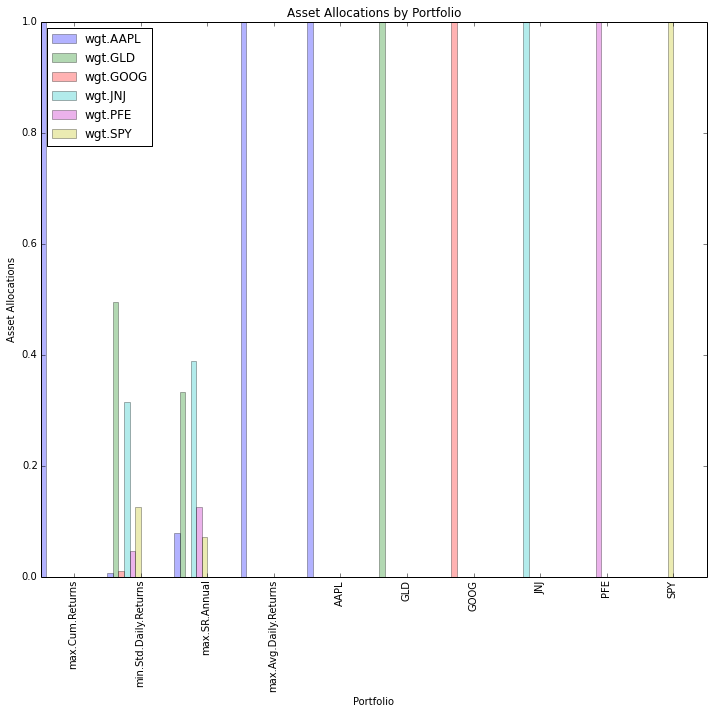

In [241]:
clrPlt = ['b', 'g', 'r', 'c', 'm', 'y']
nGrps = optPltDf.shape[0]
fgr, ax = plt.subplots(figsize = (10, 10))
index = np.arange(0, nGrps)
barWdt = 0.5
opacity = 0.3
# print [name for name in optPltDf.columns.tolist() if "wgt." in name]
barPos = 0.0
assetLst = [name for name in optPltDf.columns.tolist() if "wgt." in name]
assert (len(clrPlt) >= len(assetLst))
for assetIx, assetSym in enumerate(assetLst):
    rctSym = plt.bar(index + barPos, optPltDf[assetSym], barWdt * 1. / len(assetLst),
                     alpha = opacity, color = clrPlt[assetIx], 
                     label = assetSym)
    barPos += barWdt * 1. / len(assetLst)    
    
plt.xlabel('Portfolio')
plt.ylabel('Asset Allocations')
plt.title('Asset Allocations by Portfolio')
# print index + barWdt
plt.xticks(index + barWdt, optPltDf['metric'], rotation = 90)
lgn = plt.legend(loc = 'best')
# lgn = plt.legend(loc = 'lower right')
# lgnBB = lgn.legendPatch.get_bbox().inverse_transformed(ax.transAxes)
# # print lgnBB
# lgn.set_bbox_to_anchor(lgnBB)
plt.tight_layout()
plt.savefig('weights_v1.png')
plt.show()

['cumRtn', 'avgDlyRtn', 'stdDlyRtn', 'annualSR']


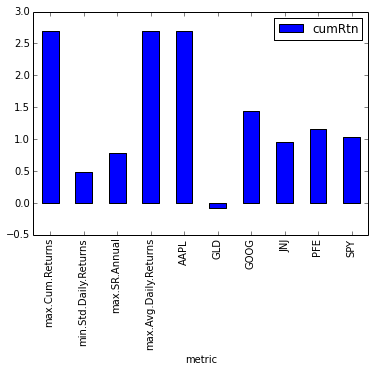

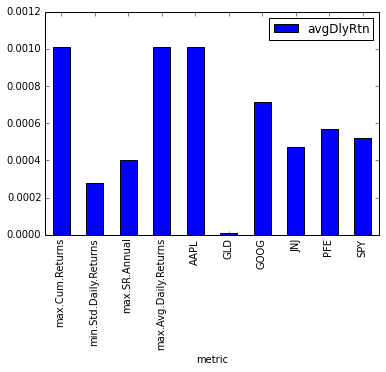

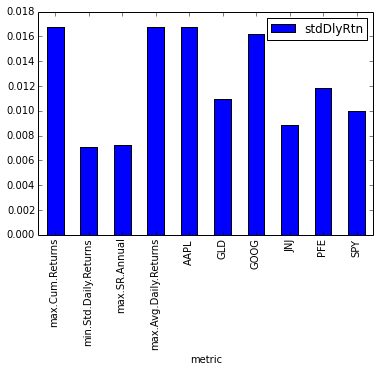

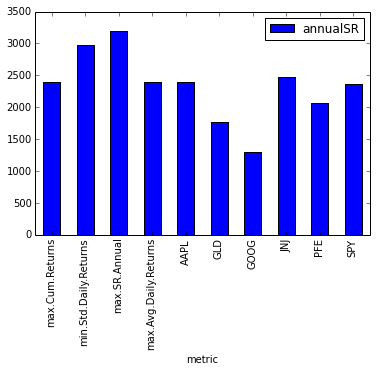

In [242]:
metricLst = ['cumRtn', 'avgDlyRtn', 'stdDlyRtn', 'annualSR']
print metricLst
for metric in metricLst:
    optPltDf.plot(x = 'metric', y = metric, kind = 'bar')
    plt.show()

### Portfolio Metrics Plot

['cumRtn', 'avgDlyRtn', 'stdDlyRtn', 'annualSR']
<type 'numpy.ndarray'>


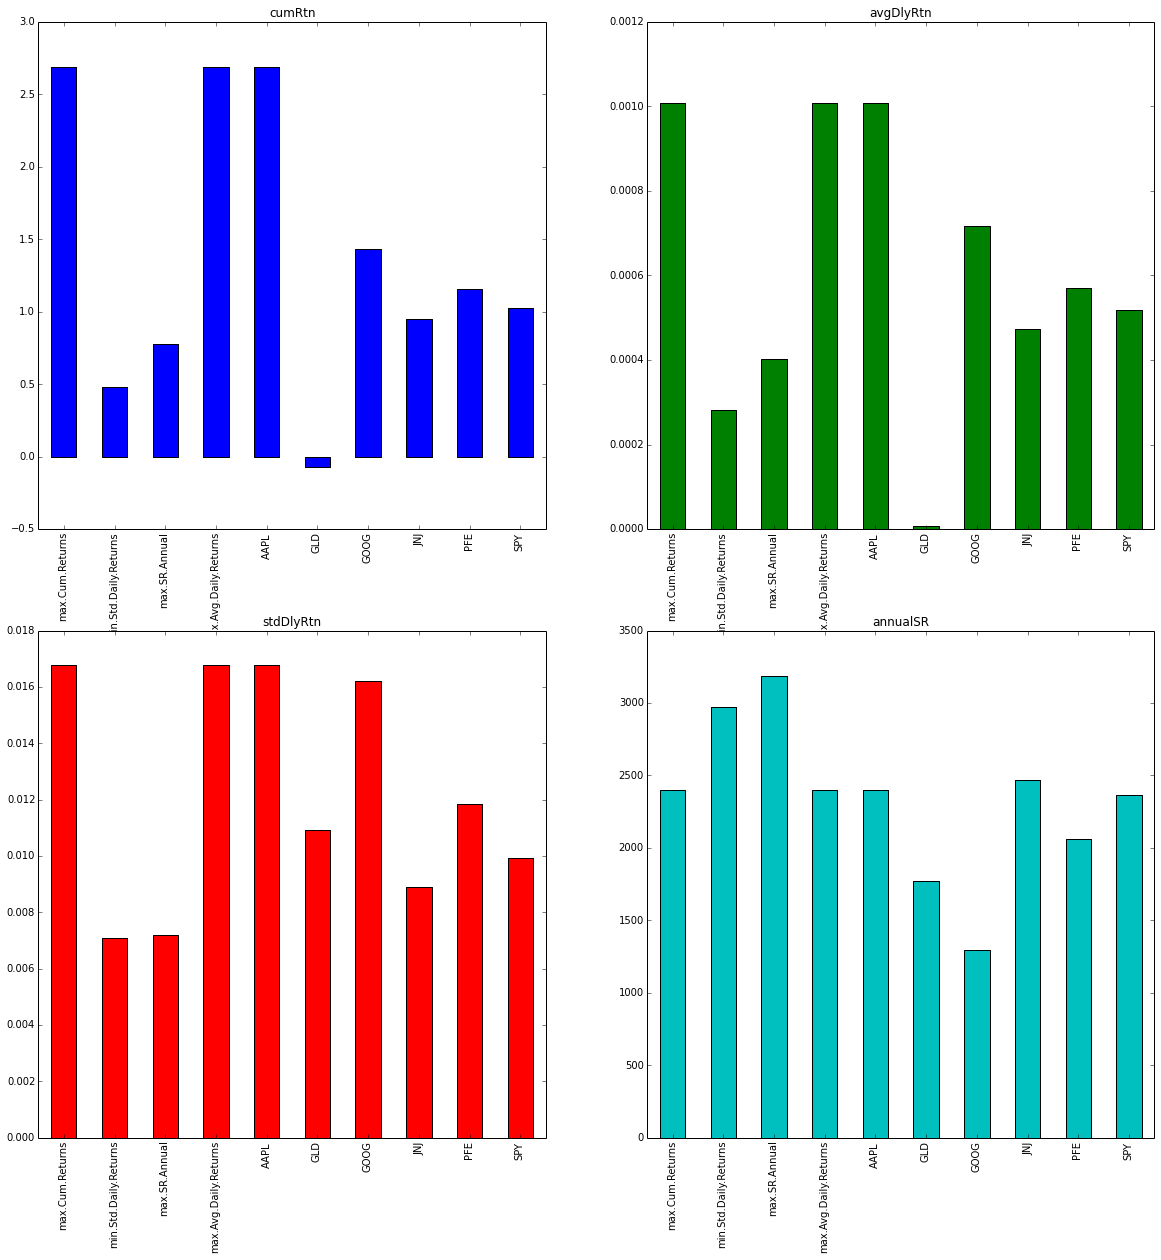

In [243]:
metricLst = ['cumRtn', 'avgDlyRtn', 'stdDlyRtn', 'annualSR']
print metricLst
nrows = 2; ncols = 2;
fgr, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 20))
print type(axs)
for metricIx, metric in enumerate(metricLst):
    sax = optPltDf[metric].plot(ax = axs[metricIx / nrows, metricIx % nrows], kind = 'bar',
                               color = clrPlt[metricIx])
    axs[metricIx / nrows, metricIx % nrows].set_title(metric)
    sax.set_xticklabels(optPltDf['metric'], rotation = 90)
    
plt.savefig('metrics_v1.png')    
plt.show()